<a href="https://colab.research.google.com/github/faraix/IMBIZO2022_DS_Tutorial/blob/main/LFADs_rsfMRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Unsupervised representation learning of cortical resting state fMRI activity**

Modelling Dynamic rsfMRI Activity with Latent Factor Analysis via Dynamical Systems

Farai Mberi

## Setups

In [4]:
import datetime
import h5py
!pip install jax
import jax.numpy as jnp
from jax import random
from jax.experimental import optimizers
from jax.config import config
from jax.nn import relu
from jax.random import poisson as jpoisson
#config.update("jax_debug_nans", True) # Useful for finding numerical errors
import matplotlib.pyplot as plt
import numpy as np  # original CPU-backed NumPy
import scipy.signal
import scipy.stats
import os
import sys
import time
from importlib import reload
from tqdm import tqdm
import plotly.express as px
import pandas as pd
import time
plt.rcParams.update({'font.size': 18})

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

start = time.time()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


ImportError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
from glob import glob
import scipy.io as sio
import numpy as np
import os.path
import pandas as pd

#import dataset
path = '/content/drive/MyDrive/Atlas/data_fmri.csv'


# csv files in the path
df = pd.read_csv(path)
x=df.drop(['Unnamed: 0'], axis=1)



In [5]:
x_matrix=x.values

In [6]:
x_matrix.shape

(297600, 128)

In [7]:
x_matrix_3d = np.reshape(x_matrix, (-1, 200, 128))

In [8]:
x_matrix_3d.shape

(1488, 200, 128)

In [9]:
! git clone -b SA_tutorial https://github.com/NinelK/jax-lfads

Cloning into 'jax-lfads'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 447 (delta 75), reused 67 (delta 63), pack-reused 342
Receiving objects: 100% (447/447), 29.49 MiB | 10.58 MiB/s, done.
Resolving deltas: 100% (263/263), done.


In [10]:
# You must change this to the location of the computation-thru-dynamics directory.
HOME_DIR = '/content' 


import os
import sys

sys.path.append(os.path.join(HOME_DIR,'jax-lfads'))

import lfads_tutorial.lfads as lfads
import lfads_tutorial.plotting as plotting
import lfads_tutorial.utils as utils
from lfads_tutorial.optimize import optimize_lfads, get_kl_warmup_fun
from lfads_tutorial.lfads import sigmoid

import matplotlib.pyplot as plt
import pandas as pd
#from nlb_tools.nwb_interface import NWBDataset


ImportError: ignored

In [18]:
# Make directories
lfads_dir = '/content/lfads/'       # where to save lfads data and parameters to
output_dir = os.path.join(lfads_dir, 'output/')
figure_dir = os.path.join(lfads_dir, os.path.join(output_dir, 'figures/'))
if not os.path.exists(lfads_dir):
    os.makedirs(output_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

In [ ]:
threeD = x_matrix_3d
threeD.shape

(1488, 200, 128)

In [ ]:
indices_1 = np.random.permutation(threeD.shape[1])
data_bxtxn = threeD[:,indices_1,:]

In [ ]:
print(indices_1)

[139   0 103 190 196  74 104  24 137 120 129 199 188  14   3   9 189 126
 151 124 163  30 140 127 161  85 100 146  54 173 171   4  35  62 107  60
  58  15  17  21  33  59  38 130 197 134  92  79 162  25  88  16 166  56
  70 175  99 169  89  57 154 113  72 185  77 179  98 112  69 181 149   1
 144   7 198  49  31  80 143 153  51  44  39 159  64 121  53 194 125  94
  67  20 148  68 157 115  12  18  37 142 187  43 147   2  11 155  10  84
 136 160 117  45 152  91 156 172  13 106  97  19 110 186  76 174   6  52
  81  47  82 101  28   8  34 193  23 116 111 109 145 119  41 122 102 170
  32  27  83  78 178  42 108 177 182  40  95  50  90 180  66 114  48 118
 141  87 164 133 184 195 105 132  61 183 191 168  65 123   5 167  26 176
  75 128  63  36 135 131  55  46 138 165 192  71  96  22 150  73  29  86
  93 158]


In [ ]:
data_bxtxn.shape

(1488, 200, 128)

In [ ]:
data_dt = 2000.0        # define our dt in a physiological range [ms]

train_fraction = 0.9      # Train with 90% of the synthetic data

nexamples, ntimesteps, data_dim = data_bxtxn.shape

train_data, eval_data = utils.split_data(data_bxtxn,
                                         train_fraction=train_fraction)
eval_data_offset = int(train_fraction * data_bxtxn.shape[0])

# # # find reach directions for labeling
# # conds = dataset.trial_info.set_index(['trial_type', 'trial_version']).index.unique().tolist()
# # # Loop over conditions and compute average trajectory
# # reach_angle = np.empty(len(dataset.trial_info)).astype('float32')
# # for cond in conds:
# #     # Find trials in condition
# #     mask = np.all(dataset.trial_info[['trial_type', 'trial_version']] == cond, axis=1)
# #     # Determine reach angle for color
# #     active_target = dataset.trial_info[mask].target_pos.iloc[0][dataset.trial_info[mask].active_target.iloc[0]]
# #     reach_angle[mask] = np.arctan2(*active_target[::-1])

In [ ]:
import sklearn
ncomponents = data_dim
full_pca = sklearn.decomposition.PCA(ncomponents)
full_pca.fit(np.reshape(data_bxtxn, [-1, data_dim]))

PCA(n_components=128)

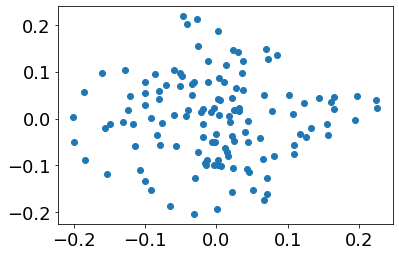

In [ ]:
plt.scatter(*full_pca.components_[:2])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


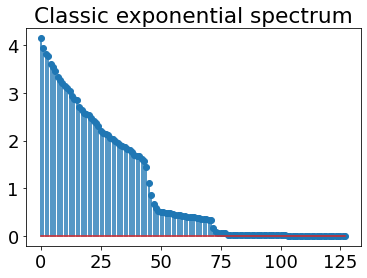

In [ ]:
plt.stem(full_pca.explained_variance_)
plt.title('Classic exponential spectrum');

### Set LFADS Parameters

In [ ]:
# LFADS Hyper parameters
data_dim = data_bxtxn.shape[2]  # input to lfads should have dimensions:
ntimesteps = data_bxtxn.shape[1] #   (batch_size x ntimesteps x data_dim)
batch_size = 100      # batch size during optimization

# LFADS architecture - The size of the numbers is rather arbitrary, 
# but relatively small because we know the integrator RNN isn't too high 
# dimensional in its activity.
enc_dim = 64         # encoder dim
con_dim = 0          # controller dim
ii_dim = 0           # inferred input dim
gen_dim = 64         # generator dim, should be large enough to generate integrator RNN dynamics
factors_dim = 8     # factors dim, should be large enough to capture most variance of dynamics

# Numerical stability
var_min = 0.001 # Minimal variance any gaussian can become.

# Optimization HPs that percolates into model
l2reg = 0.00002

# Initial state prior parameters
# the mean is set to zero in the code
ic_prior_var = 0.1 # this is $\sigma^2_p$ in above paragraph

# Inferred input autoregressive prior parameters
ar_mean = 0.0                 # process mean
ar_autocorrelation_tau = 1.0  # seconds, how correlated each time point is, related to $\phi$ above.
ar_noise_variance = 0.1       # noise variance

lfads_hps = {'data_dim' : data_dim, 'ntimesteps' : ntimesteps,
             'enc_dim' : enc_dim, 'con_dim' : con_dim, 'var_min' : var_min,
             'ic_prior_var' : ic_prior_var, 'ar_mean' : ar_mean,
             'ar_autocorrelation_tau' : ar_autocorrelation_tau,
             'ar_noise_variance' : ar_noise_variance,
             'ii_dim' : ii_dim, 'gen_dim' : gen_dim,
             'factors_dim' : factors_dim,
             'l2reg' : l2reg,
             'batch_size' : batch_size}

num_batches = 5000         # how many batches do we train
print_every = 100            # give information every so often

# Learning rate HPs
step_size = 0.01            # initial learning rate
decay_factor = 0.9998       # learning rate decay param
decay_steps = 1             # learning rate decay param

# Regularization HPs
keep_rate = 0.6             # dropout keep rate during training ,0.95 before

# Numerical stability HPs
max_grad_norm = 10.0        # gradient clipping above this value

# The fact that the start and end values are required to be floats is something I need to fix.
kl_warmup_start = 0.0 # batch number to start KL warm-up, explicitly float
kl_warmup_end = 1000.0  # batch number to be finished with KL warm-up, explicitly float
kl_min = 0.001 # The minimum KL value, non-zero to make sure KL doesn't grow crazy before kicking in.
kl_max = 1.

lfads_opt_hps = {'num_batches' : num_batches, 'step_size' : step_size,
                 'decay_steps' : decay_steps, 'decay_factor' : decay_factor,
                 'kl_min' : kl_min, 'kl_max' : kl_max, 'kl_warmup_start' : kl_warmup_start,
                 'kl_warmup_end' : kl_warmup_end, 'keep_rate' : keep_rate,
                 'max_grad_norm' : max_grad_norm, 'print_every' : print_every,
                 'adam_b1' : 0.9, 'adam_b2' : 0.999, 'adam_eps' : 1e-4}

class hashabledict(dict):
    def __hash__(self):
        return hash(tuple(sorted(self.items())))

lfads_hps = hashabledict(lfads_hps)
lfads_opt_hps = hashabledict(lfads_opt_hps)

assert num_batches >= print_every and num_batches % print_every == 0

### Initialize LFADS

In [ ]:
# Initialize parameters for LFADS
from functools import partial

rnn_type = 'gru'
if rnn_type=='vrnn':
  nonlin = lambda x: jnp.tanh(x)
  model = partial(vanilla_rnn, **{'nonlin': nonlin})
  model_params = vanilla_rnn_params
elif rnn_type=='vrnn_relu':
  nonlin = lambda x: relu(x)
  model = partial(vanilla_rnn, **{'nonlin': nonlin})
  model_params = vanilla_rnn_params
elif rnn_type=='gru':
  # to get the results like in Nature Methods
  model = lfads.gru
  model_params = lfads.gru_params
else:
  raise ValueError('Unknown type')
  
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
init_params = lfads.lfads_params(key, lfads_hps, gen_rnn_params=model_params)

### Option 1: Train LFADS

In [ ]:
# Takes 29 minutes to train on a GPU; first step takes ~60 sec.
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
trained_params, opt_details = \
    optimize_lfads(key, init_params, lfads_hps, lfads_opt_hps,\
                   data_bxtxn, eval_data, gen=model)

Batches 1-100 in 119.06 sec, Step size: 0.00980
    Training losses 50852 = NLL 50852 + KL IC 17,0 + KL II 0,0 + L2 0.04
        Eval losses 50860 = NLL 50860 + KL IC 17,0 + KL II 0,0 + L2 0.04
Batches 101-200 in 62.62 sec, Step size: 0.00961
    Training losses 50855 = NLL 50855 + KL IC 5,0 + KL II 0,0 + L2 0.05
        Eval losses 50862 = NLL 50862 + KL IC 5,1 + KL II 0,0 + L2 0.05
Batches 201-300 in 63.23 sec, Step size: 0.00942
    Training losses 50861 = NLL 50860 + KL IC 3,1 + KL II 0,0 + L2 0.05
        Eval losses 50867 = NLL 50866 + KL IC 3,1 + KL II 0,0 + L2 0.05
Batches 301-400 in 69.32 sec, Step size: 0.00923
    Training losses 50844 = NLL 50843 + KL IC 1,0 + KL II 0,0 + L2 0.06
        Eval losses 50859 = NLL 50858 + KL IC 1,0 + KL II 0,0 + L2 0.06
Batches 401-500 in 61.34 sec, Step size: 0.00905
    Training losses 50879 = NLL 50879 + KL IC 1,0 + KL II 0,0 + L2 0.06
        Eval losses 50868 = NLL 50867 + KL IC 1,0 + KL II 0,0 + L2 0.06
Batches 501-600 in 63.55 sec, Step

In [ ]:
fname_uniquifier = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
network_fname = (f'trained_params_lfads_pend_{rnn_type}' + fname_uniquifier + '.npz')
network_path = os.path.join(output_dir, network_fname)

print("Saving parameters: ", network_path)
np.savez(network_path, trained_params)


NameError: ignored

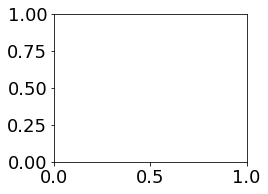

In [ ]:
# Plot the training details
x = np.arange(0, num_batches, print_every)
plt.figure(figsize=(20,6))
plt.subplot(251)
plt.plot(x, opt_details['tlosses']['total'], 'k')
plt.ylabel('Training')
plt.title('Total loss')
plt.subplot(252)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.title('Negative log p(z|x)')
plt.subplot(253)
plt.plot(x, opt_details['tlosses']['kl_ii'], 'r')
plt.title('KL inferred inputs')
plt.subplot(254)
plt.plot(x, opt_details['tlosses']['kl_g0'], 'g')
plt.title('KL initial state')
plt.subplot(255)
plt.plot(x, opt_details['tlosses']['l2'], 'c')
plt.xlabel('Training batch')
plt.title('L2 loss')
plt.subplot(256)
plt.plot(x, opt_details['elosses']['total'], 'k')
plt.xlabel('Training batch')
plt.ylabel('Evaluation')
plt.subplot(257)
plt.plot(x, opt_details['tlosses']['nlog_p_xgz'], 'b')
plt.xlabel('Training batch')
plt.subplot(258)
plt.plot(x, opt_details['elosses']['kl_ii'], 'r')
plt.xlabel('Training batch')
plt.subplot(259)
plt.plot(x, opt_details['elosses']['kl_g0'], 'g')
plt.xlabel('Training batch');

NameError: ignored

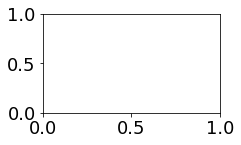

In [ ]:
# See the effect of the KL warmup, which is shown 
# by the KL penalities without the warmup scaling. 
plt.figure(figsize=(7,4))
plt.subplot(221)
plt.plot(x, opt_details['tlosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Training')
plt.subplot(222)
plt.plot(x, opt_details['tlosses']['kl_g0_prescale'], 'g--')
plt.subplot(223)
plt.plot(x, opt_details['elosses']['kl_ii_prescale'], 'r--')
plt.ylabel('Evaluation')
plt.xlabel('Training batch')
plt.subplot(224)
plt.plot(x, opt_details['elosses']['kl_g0_prescale'], 'g--')
plt.xlabel('Training batch');

### Option 2: Load pre-trained model from file

In [ ]:
# After training, you can load these up, after locating the save file.
# network_fname = 'trained_params_lfads_128_vrnn2022-08-05_14:02:03.npz'
network_fname = 'trained_params_lfads_pend_gru2022-09-02_13 58 14.npz'
network_path = os.path.join(output_dir, network_fname)

loaded_params = np.load(network_path, allow_pickle=True)
trained_params = loaded_params['arr_0'].item()


## Visualize latent space trajectories

In [ ]:
# Plot a bunch of examples of eval trials run through LFADS.
reload(plotting)
#reload(lfads)

# def plot_rescale_fun(a): 
#     fac = max_firing_rate * data_dt
#     return renormed_fun(a) * fac


bidx = 1

nexamples_to_save = 1
for eidx in range(nexamples_to_save):
    fkey = random.fold_in(key, eidx)
    psa_example = eval_data[bidx,:,:].astype(jnp.float32)
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)

    # The inferred input and true input are rescaled and shifted via 
    # linear regression to match, as there is an identifiability issue. there.
    # plotting.plot_lfads(psa_example, psa_dict,
    #                     data_dict, eval_data_offset+bidx, plot_rescale_fun)


dict_keys(['c_t', 'factor_t', 'gen_t', 'ic_logvar', 'ic_mean', 'ii_logvar_t', 'ii_mean_t', 'ii_t', 'lograte_t', 'xenc_t'])

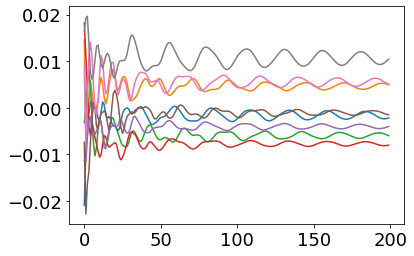

In [ ]:
# plt.plot(psa_dict['factor_t'])
plt.plot(psa_dict['factor_t'])
psa_dict.keys()

In [ ]:

print(psa_dict['factor_t'].shape)
for idx in range(8):
  peaks_sig = scipy.signal.find_peaks(psa_dict['factor_t'][50:, idx])
  print(np.diff(peaks_sig[0]))

(200, 8)
[24 25 26 25 25]
[ 8 13 10 24 28 24 24]
[12  9 15  6 23 24 25 26]
[29 23 24 26 25]
[11 13 26 26 24 25]
[11 10 13  7 23 23 24 26]
[ 6 23 24 25 25 25]
[23 27 25 25 25]


In [ ]:
# sample trajectories
ics = np.empty((data_bxtxn.shape[0],gen_dim))
gen_traj = np.empty((data_bxtxn.shape[0],ntimesteps,gen_dim))
for i, psa_example in enumerate(data_bxtxn.astype(jnp.float32)):
    psa_dict = lfads.posterior_sample_and_average_jit(trained_params, lfads_hps, 
                                                      fkey, psa_example, gen=model)
    ics[i] = psa_dict['ic_mean']
    gen_traj[i] = psa_dict['gen_t']

In [ ]:
ics.shape

(1488, 64)

In [ ]:
gen_traj.shape

(1488, 200, 64)

In [ ]:
ncomponents = 64
pca = PCA(ncomponents)
pca.fit(np.reshape(gen_traj, [-1, gen_dim]))

S = pca.components_.T
print(S.shape)
# for t in gen_traj:
#   plt.plot(*(t@S)[:,[1,2]].T, c=plt.cm.rainbow(a / (2*np.pi) + 0.5),alpha=0.5)



(64, 64)


In [ ]:


# print((gen_traj@S)[:,0])

df = pd.DataFrame.from_dict({'PC0': (gen_traj@S)[::10,:,0].flatten(),
                             'PC1': (gen_traj@S)[::10,:,1].flatten(),
                             'PC2': (gen_traj@S)[::10,:,2].flatten()})

fig = px.scatter_3d(df, x="PC0", y="PC1", z="PC2")
fig.update_traces(marker=dict(size=3,
                              line=dict(width=.01,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig.show()

In [ ]:
from sklearn.manifold import TSNE

ncomponents = 64
tsne = TSNE(ncomponents)#,perplexity=20)
embedded_ics = tsne.fit_transform(ics)

plt.scatter(*embedded_ics[:,:2].T ,alpha=0.5)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



ValueError: ignored

## Fixed point analysis

In [ ]:
%load_ext autoreload
%autoreload 2
import fixed_point_finder.fixed_points as fp_optimize
from jax import vmap
import gc

gc.collect() # free up some RAM

In [ ]:
# These are some preliminaries. 
x_star = np.zeros(ii_dim)  # We always linearize the input around zero in this example.

# Make a one parameter function of thie hidden state, useful for jacobians.
key = random.PRNGKey(np.random.randint(0, utils.MAX_SEED_INT))
rnn_fun = lambda h : model(trained_params['gen'], h, x_star)
batch_rnn_fun = vmap(rnn_fun, in_axes=(0,))


#### Create some functions that define the fixed point loss
which is just the squared error of a point  for a discrete time system such as a VRNN or GRU.

In [ ]:
fp_loss_fun = fp_optimize.get_fp_loss_fun(rnn_fun)
total_fp_loss_fun = fp_optimize.get_total_fp_loss_fun(rnn_fun)

We have to start the fixed point finder with some points, and it's usually ok to start with examples of where the state normally operates.... but not here ;) Here I 'helped' the model to find the fixed point that I'm interested in by starting closer to 0.


In [ ]:
fp_candidates = jnp.array(gen_traj[::50,])                        # was batch x time x dim
fp_candidates = jnp.reshape(fp_candidates/10, (-1, gen_dim))      # now (batch * time) x dim

In [ ]:
# Fixed point optimization hyperparameters
fp_num_batches = 1000         # Total number of batches to train on.
fp_batch_size = 100          # How many examples in each batch
fp_step_size = 0.2          # initial learning rate
fp_decay_factor = 0.9999     # decay the learning rate this much
fp_decay_steps = 1           #
fp_adam_b1 = 0.9             # Adam parameters
fp_adam_b2 = 0.999
fp_adam_eps = 1e-5
fp_opt_print_every = 200   # Print training information during optimziation every so often

# Fixed point finding thresholds and other HPs
fp_noise_var = 0.0      # Gaussian noise added to fixed point candidates before optimization.
fp_opt_stop_tol = 0.00001  # Stop optimizing when the average value of the batch is below this value.
fp_tol = 0.00001        # Discard fps with squared speed larger than this value.
fp_unique_tol = 0.25      # tolerance for determination of identical fixed points
fp_outlier_tol = 1.0    # Anypoint whos closest fixed point is greater than tol is an outlier.


In [ ]:
fp_candidates.shape

In [ ]:
reload(fp_optimize)

fp_tols = [0.0001, 0.00002] # Used for both fp_tol and opt_stop_tol

all_fps = {}
for tol in fp_tols:
  fp_hps = {'num_batches' : fp_num_batches, 'step_size' : fp_step_size, 
            'decay_factor' : fp_decay_factor, 'decay_steps' : fp_decay_steps, 
            'adam_b1' : fp_adam_b1, 'adam_b2' : fp_adam_b2,
            'adam_eps' : fp_adam_eps, 'noise_var' : fp_noise_var, 
            'fp_opt_stop_tol' : tol, 'fp_tol' : tol, 
            'unique_tol' : fp_unique_tol, 'outlier_tol' : fp_outlier_tol, 
            'opt_print_every' : fp_opt_print_every}

  fp_hps = hashabledict(fp_hps)

  fps, fp_losses, fp_idxs, fp_opt_details = \
    fp_optimize.find_fixed_points(rnn_fun, fp_candidates, fp_hps, do_print=True)
  if len(fp_idxs) > 0:
      F_of_fps = batch_rnn_fun(fps)
  else:
      F_of_fps = np.zeros([0,gen_dim])
      
  all_fps[tol] = {'fps' : fps, 'candidates' : fp_candidates[fp_idxs],
                  'losses' : fp_losses, 'F_of_fps' : F_of_fps, 
                  'opt_details' : fp_opt_details, 'hps' : fp_hps}

  all_fps[tol]


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# print((gen_traj@S)[:,0])

df = pd.DataFrame.from_dict({'PC0': (gen_traj@S)[::10,:,0].flatten(),
                             'PC1': (gen_traj@S)[::10,:,1].flatten(),
                             'PC2': (gen_traj@S)[::10,:,2].flatten(),
                             'color': reach_angle[::10].repeat(ntimesteps).T})

fig = px.scatter_3d(df, x="PC0", y="PC1", z="PC2",color='color')
fig.update_traces(marker=dict(size=3,
                              line=dict(width=.01,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))

fixed_points = all_fps[0.00002]['fps'] @ S
print(fixed_points.shape)

fig.add_trace(
    go.Scatter3d(x=fixed_points[:,0],
                 y=fixed_points[:,1],
                 z=fixed_points[:,2],
                 mode='markers')
)
fig.show()


### Exercise 4: Linearizing around the fixed point: calculating the Jacobian

In [ ]:
jacs = fp_optimize.compute_jacobians(rnn_fun, all_fps[0.0001]['fps'])
i=0 # choose a fixed point
J = np.array(jacs[i]) # getting the jacobian for i-th fixed point
eig_decomps = np.linalg.eig(J) # calculating eigenvalues

In [ ]:
plt.figure(figsize=(4,4))
eigvals = eig_decomps[0]#['evals']
plt.scatter(eigvals.real, eigvals.imag)
x = jnp.linspace(-jnp.pi,jnp.pi,100)
plt.plot(jnp.sin(x),jnp.cos(x),c='k')
# plt.plot(x,jnp.cos(x))
# scale = np.sqrt(eigvals.real**2 + eigvals.imag**2).max()*1.05
scale=1
plt.xlim([-scale,+scale])
plt.ylim([-scale,+scale])
plt.xlabel('Re')
plt.ylabel('Im')

In [ ]:
end = time.time()

(end-start)/60

## References
<a name="references"></a>
0. [Computation through dynamics tutorial](https://github.com/google-research/computation-thru-dynamics) from David Sussillo, which contains an implementation of LFADS that was adapted to this tutorial + extra material (in depth LFADS tutorial, inferring unobserved inputs, FORCE training)

1. *Manifold hypothesis:* Gallego, Juan A., et al. "Neural manifolds for the control of movement." Neuron 94.5 (2017): 978-984.

2. *A review of a population dynamics models:* Vyas, Saurabh, et al. "Computation through neural population dynamics." Annual Review of Neuroscience 43 (2020): 249. [Not paywalled pdf.](https://web.stanford.edu/~mgolub/publications/2020-Vyas-ARN.pdf)

3. *Our review on fully observed vs latent dynamical models*: Hurwitz, Cole, et al. [Building population models for large-scale neural recordings: Opportunities and pitfalls.](https://arxiv.org/pdf/2102.01807.pdf) Current Opinion in Neurobiology 70 (2021): 64-73.

4. *For better understanding of PCA:* [Dimensionality reduction tutorial](https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/chapter_title.html) by Alex Cayco Gajic at Neuromatch Academy

5. *The LFADS paper:* Pandarinath, Chethan, et al. [Inferring single-trial neural population dynamics using sequential auto-encoders.](https://www.nature.com/articles/s41592-018-0109-9) Nature methods 15.10 (2018): 805-815.

6. *Critical view on rotational dynamics* Lebedev, Mikhail A., et al. "Analysis of neuronal ensemble activity reveals the pitfalls and shortcomings of rotation dynamics." Scientific Reports 9.1 (2019): 1-14.
  
## Interesting recent papers for further reading

If you want to know what's going on in the field right now, you can check the following papers (a very biased selection from Nina ;) ):

1. Smith, Jimmy, Scott Linderman, and David Sussillo. [Reverse engineering recurrent neural networks with jacobian switching linear dynamical systems.](https://arxiv.org/pdf/2111.01256.pdf) Advances in Neural Information Processing Systems 34 (2021): 16700-16713.
2. 

# Project

Pick another dataset (e.g. MC_RTT) from a [Neural Latents Benchmark](https://neurallatents.github.io/datasets.html) project. Follow the pre-processing notebook (available of NLB website) in order to align the data. Following the methods you learned today, analyse trial-average responses with dimensionality reduction techniques. Train a single-trial dynamical model to the data and analyse the latent dynamics (you can use the code from this notebook). 

Do your results agree with the type of computation that the neurons were supposed to perform?